<font size="5">
Author: Weigang Liang<br><br>
This is a walkthrough of the Markov chain Monte Carlo code used in the Liang and Broquet IBC paper.<br><br>
The gravity field model can be found at https://pds-geosciences.wustl.edu/grail/grail-l-lgrs-5-rdr-v1/grail_1001/shadr/ and the topography model can be obtained at https://zenodo.org/records/3870924
</font>

In [1]:
#importing the required modules and defining constants
import pyshtools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

a = 1738000
gm = 4902.80011526323e9

In [2]:
#we are using spherical harmonics (~time-series analysis), so we need a resolution parameter

lmax_calc = 150 

In [3]:
#extracting the necessary data

clm0 = pyshtools.SHGravCoeffs.from_file('gggrx_1200a_sha.tab.txt', errors=True, header_units='km',lmax=lmax_calc)
shape = pyshtools.SHCoeffs.from_file('MoonTopo2600p.shape.sh',lmax=lmax_calc)


In [4]:
#basic data cleaning and pre-processing. Actual data cleaning/pre-processing takes 10x more lines (see mare_fill.py)

interface0 = shape.to_array()
bc = pyshtools.SHGravCoeffs.from_shape(shape, rho=2500, gm=gm, lmax=lmax_calc,nmax=9)#3100
bc2 = bc.change_ref(r0=a,gm=gm,lmax=lmax_calc)
clm0 = clm0.change_ref(r0=a,gm=gm,lmax=lmax_calc)

clm = clm0 - bc2

cilm = clm.to_array()
cilm[0][0][0] = 1
cilm[:,1:10,:] = 0

L = np.arange(0,lmax_calc+1)
L1 = round(0.9*lmax_calc)#-25
L2 = lmax_calc

taper0 = (1-np.cos((L2-L)/(L2-L1)*np.pi))/2
taper = np.tile(taper0,(L2+1,1)).transpose()

taperf = np.zeros((2,L2+1,L2+1))
taperf[0,:,:] = taper
taperf[1,:,:] = taper

cilm[:,L1:,:] = taperf[:,L1:,:]*cilm[:,L1:,:]

In [5]:
#calculating gravity

r,t,p,grav,pot = pyshtools.gravmag.MakeGravGridDH(cilm,gm,a,lmax=lmax_calc,a=a,f=0,omega=0,normal_gravity=1)


In [6]:
# shifting gravity map horizontally so the lunar nearside (what we see in the night sky) is at the center

grav_moon = np.roll(grav, shift=grav.shape[1]//2, axis=1)

(-0.5, 603.5, 301.5, -0.5)

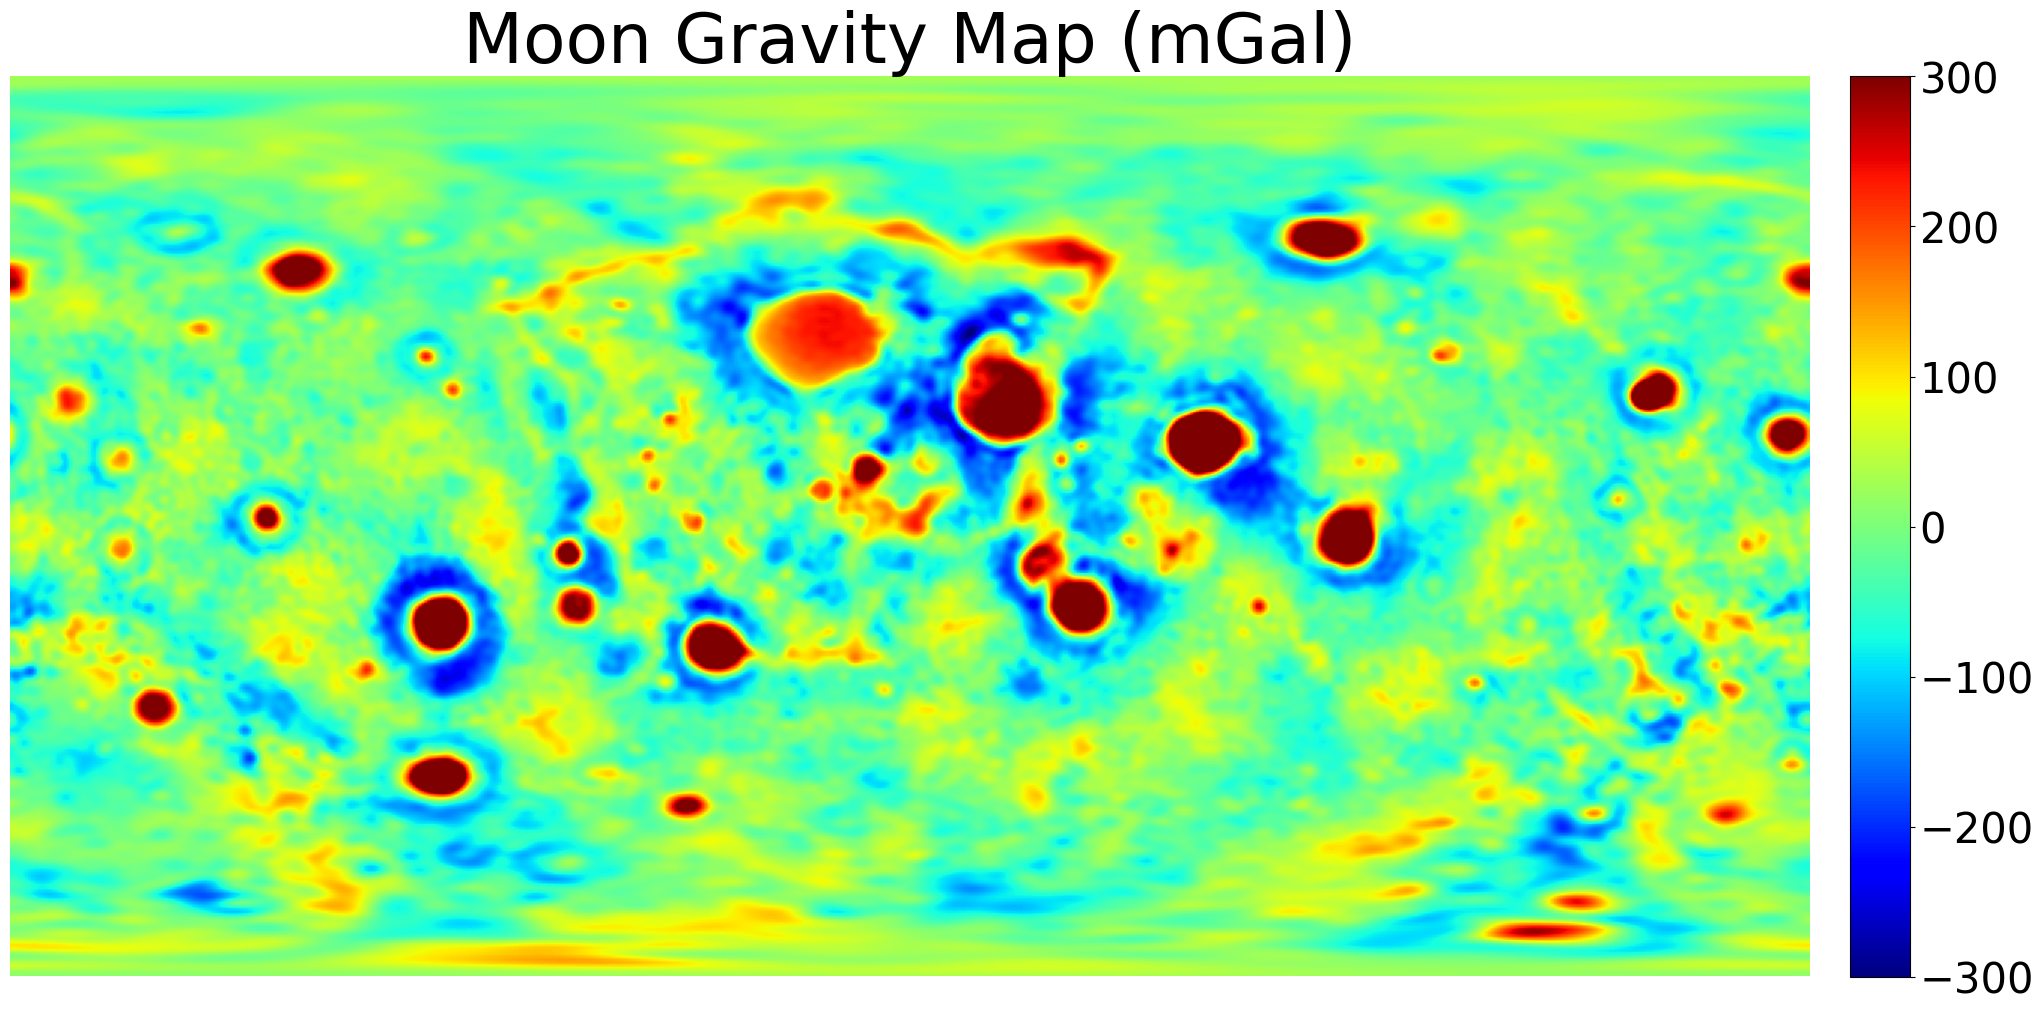

In [9]:
#plotting gravity

plt.figure(figsize=(20,10))
ax = plt.axes([0, 0.05, 0.9, 0.9 ])
ax.set_title('Moon Gravity Map (mGal)',fontsize=50)
fig = plt.imshow(grav_moon*1e5,cmap='jet',aspect='equal',vmin=-300,vmax=300)

cax = plt.axes([0.92, 0.05, 0.03,0.9 ])
cb = plt.colorbar(fig,cax=cax)
cb.ax.tick_params(labelsize=30)


ax.axis('off')

<font size="5">

The above is the Bouguer gravity map. 



<hr style="border-top: 3px solid black;">

<font size="5">

MCMC Analysis


<font size="5">

The depth and dimensions of the anomalies can be constrained using Markov chain Monte Carlo (MCMC) analysis. This involves the fitting the observed gravity of the anomalies by calculating the gravity of a proposed structure using various depths, widths, and thicknesses.

In [10]:
iterations = 500
# run MCMC code (see mcmc_demo.py)
from mcmc_demo import mcmc
mcmc(iterations)

Top Depth: 52.7 (48.7+4.16,-5.15) km
Width: 177.0 (161.0+22.5,-27.6) km
Thickness = 59.2 (64.2+11.6,-12.4) km
RMS: 8.45 mGal
Total runtime: 0.469 min


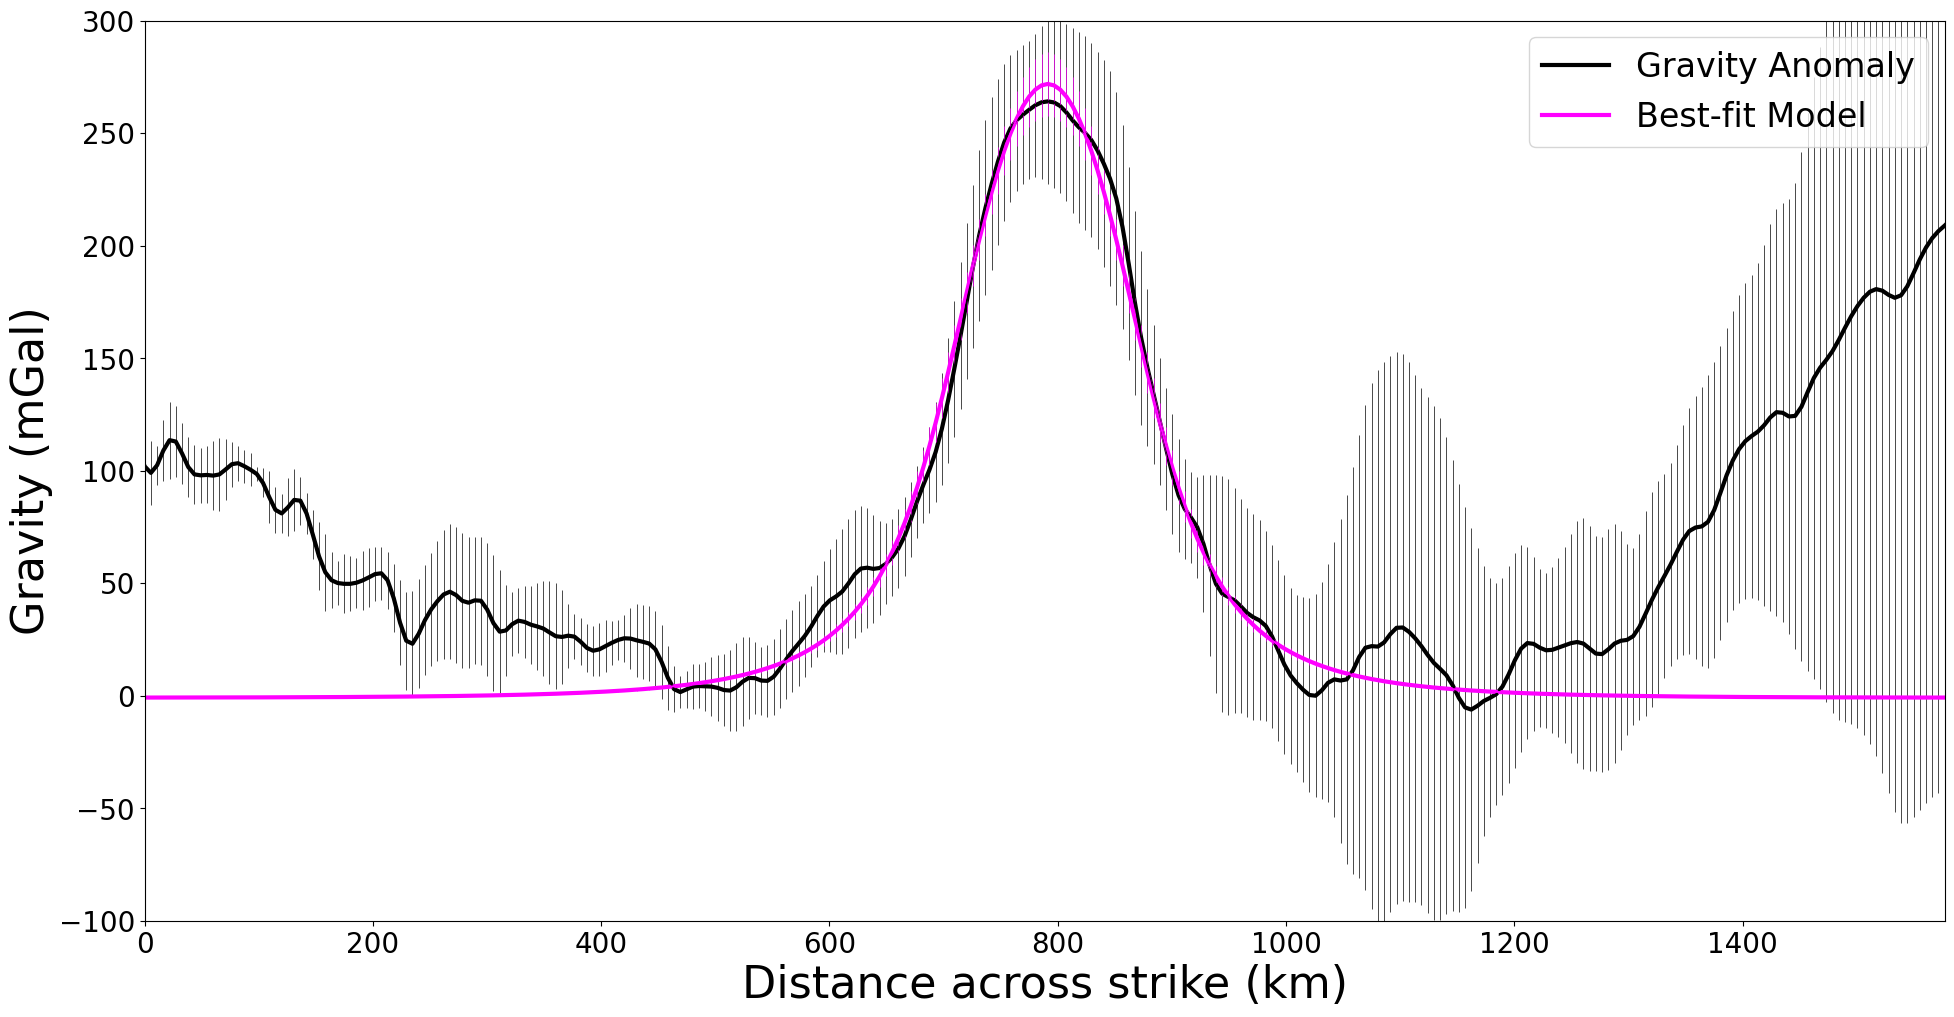

In [11]:
#extracting best-fit parameters

df = pd.read_excel('tri.xlsx')

num = 0

# Adding data
td = float(df.iloc[num, 1][:4])*1e3
xs = float(df.iloc[num, 2][:4])*1e3
th = float(df.iloc[num, 3][:4])*1e3

#plotting MCMC best-fit model vs observed data

from plot_mcmc import plott
plott(td,xs,th)


<font size="5">

Figure 3b from the main text

